In [ ]:
#unziping the file
from zipfile import ZipFile
file_name = '/content/breast-ultrasound-images-dataset.zip'

with ZipFile(file_name, 'r') as zipn:
  zipn.extractall()
  print('Done')

Done



## Libraries Import

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')

In [ ]:
import tensorflow as tf
import tensorflow.image as tfi
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dropout, Input, MaxPool2D, BatchNormalization, UpSampling2D, concatenate, Add, Multiply
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import MeanIoU
from tf_explain.core.grad_cam import GradCAM
from tensorflow.keras.utils import plot_model

In [ ]:
import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# !rm -r '/content/Dataset_BUSI_with_GT/normal'

## Dataset Loading

In [ ]:
main_path = '/content/Dataset_BUSI_with_GT/'
categories = sorted(os.listdir(main_path))
print(categories)

['benign', 'malignant', 'normal']


In [ ]:
def load_data(main_path):
  masks_path_1 = []
  masks_path_2 = []
  images_path = []

  for cat in categories:
    mask_list_1 = sorted(glob.glob(main_path+cat+'/*_mask.png', recursive = True))
    mask_list_2 = sorted(glob.glob(main_path+cat+'/*_mask_1.png', recursive = True))
    image_list = sorted(glob.glob(main_path+cat+'/*.png', recursive = True))

    images_fil = sorted(set(image_list)^set(mask_list_1)^set(mask_list_2))
    
    for m1 in mask_list_1:
      masks_path_1.append(m1)
    for m2 in mask_list_2:
      masks_path_2.append(m2)
    for img in images_fil:
      images_path.append(img)  

  return masks_path_1, masks_path_2, images_path

In [ ]:
masks_path_1, masks_path_2, images_path  = load_data(main_path)

In [ ]:
def load_image_or_mask(path):
  return np.round(tfi.resize(img_to_array(load_img(path))/255.,(256, 256)),4)

In [ ]:
def show_image(image, title='', cmap = None):
  plt.imshow(image, cmap=cmap, alpha=1)
  if title is not None:
    plt.title(title)
  plt.axis('off')

def show_mask(image, mask, alpha, title='', cmap=None):
  mask= np.round(mask)
  plt.imshow(image)
  plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
  if title is not None:
    plt.title(title)
  plt.axis('off')

## Data Visualization

In [ ]:
image_path = images_path[0]
mask_path = masks_path_1[0]

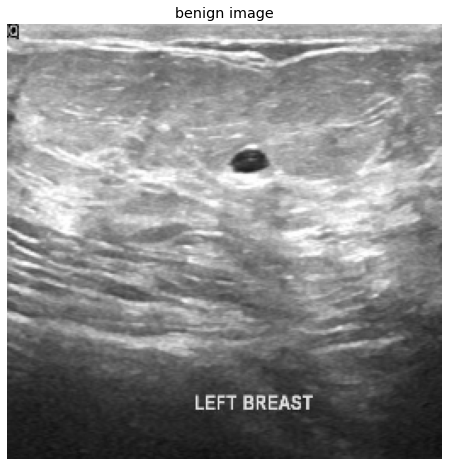

In [ ]:
plt.figure(figsize=(8,8))
show_image(load_image_or_mask(image_path), 'benign image')

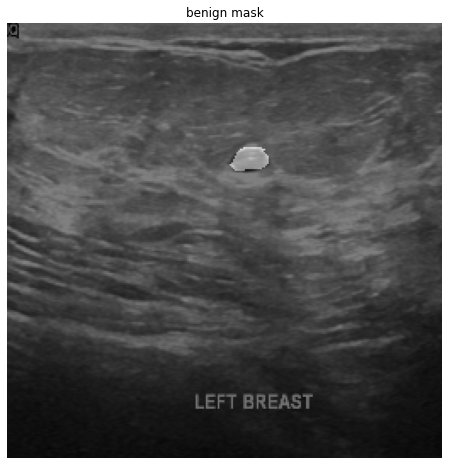

In [ ]:
plt.figure(figsize=(8,8))
show_mask(load_image_or_mask(image_path), load_image_or_mask(mask_path), alpha=0.5,title='benign mask')

## Working With Images Having Two Mask 

In [ ]:
def merge_masks():
  combine_mask = []
  combine_mask_id = []

  for path in masks_path_2:
    m2 = np.round(load_image_or_mask(path))
    m1_path = path[:-6]+'.png'

    m1 = np.round(np.round(load_image_or_mask(m1_path)))
    img = np.zeros((1,256,256,3))

    img = img + m1 + m2
    img = img[0,:,:,0]
    combine_mask.append(np.array(img))
    combine_mask_id.append(m1_path.split('/')[-1])
  return combine_mask, combine_mask_id 

In [ ]:
combine_mask, combine_mask_id = merge_masks()

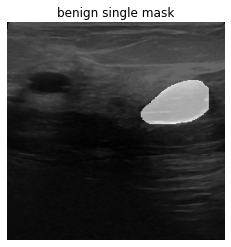

In [ ]:
show_mask(load_image_or_mask('/content/Dataset_BUSI_with_GT/benign/benign (100).png'), load_image_or_mask('/content/Dataset_BUSI_with_GT/benign/benign (100)_mask.png'), alpha=0.6,title='benign single mask')

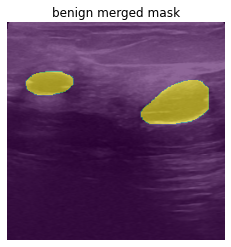

In [ ]:
show_mask(load_image_or_mask('/content/Dataset_BUSI_with_GT/benign/benign (100).png'), combine_mask[0],alpha=0.6, title='benign merged mask')

## Dataset Building

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def build_data(masks_path_1, combine_mask, combine_mask_id):
  image_data = []
  mask_data = []
  for mask_path in tqdm(masks_path_1):
    
    file_name = mask_path.split('/')[-1][:-9] + '.png'
    image_path = mask_path.replace(mask_path.split('/')[-1], file_name)

    if mask_path.split('/')[-1] in combine_mask_id:
      mask_data.append(np.expand_dims(combine_mask[combine_mask_id.index(mask_path.split('/')[-1])], 2))
      image_data.append(load_image_or_mask(image_path))
    else:
      image_data.append(load_image_or_mask(image_path))
      mask_data.append(np.expand_dims(load_image_or_mask(mask_path)[:,:,1], 2))
  return np.array(image_data), np.array(mask_data)    

In [ ]:
image_data, mask_data = build_data(masks_path_1, combine_mask, combine_mask_id) 

  0%|          | 0/780 [00:00<?, ?it/s]

## Dataset Visualization

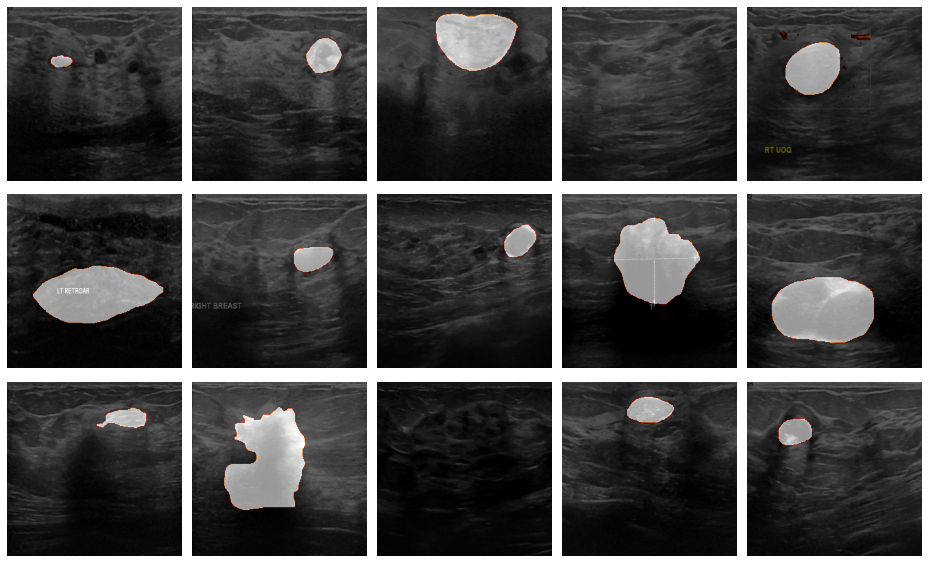

In [ ]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(image_data))
    show_mask(image_data[id], mask_data[id], alpha=0.6, cmap='gist_heat')
plt.tight_layout()
plt.show()

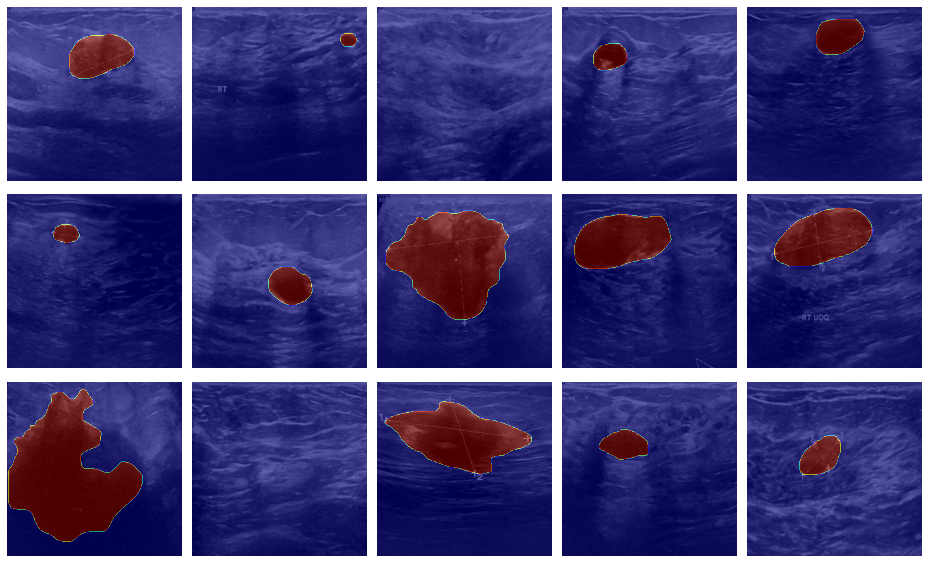

In [ ]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(image_data))
    show_mask(image_data[id], mask_data[id], alpha=0.6, cmap='jet')
plt.tight_layout()
plt.show()

## Construction of Attention U-Net

In [ ]:
# !pip -q install tf-explain

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dropout, Input, MaxPool2D, BatchNormalization, UpSampling2D, concatenate, Add, Multiply
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import MeanIoU
from tf_explain.core.grad_cam import GradCAM

In [ ]:
class EncoderBlock(Layer):
  def __init__(self, filters, rate, pooling=True, **kwargs):
    super(EncoderBlock, self).__init__(**kwargs)

    self.filters = filters
    self.rate = rate
    self.pooling = pooling

    self.cnn1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
    self.dropout = Dropout(rate)
    self.cnn2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
    self.pool = MaxPool2D()

  def call(self, X):
      x = self.cnn1(X)
      x = self.dropout(x)
      x = self.cnn2(x)
      if self.pooling:
          y = self.pool(x)
          return y, x
      else:
          return x

  def get_config(self):
      base_config = super().get_config()
      return {
          **base_config,
          "filters":self.filters,
          'rate':self.rate,
          'pooling':self.pooling
      }

In [ ]:
class DecoderBlock(Layer):
  def __init__(self, filters, rate, **kwargs):
    super(DecoderBlock, self).__init__(**kwargs)

    self.filters = filters
    self.rate = rate

    self.upsampling2d = UpSampling2D()
    self.encodeblock = EncoderBlock(filters, rate, pooling=False)

  def call(self, X):
    X, skip_X = X
    x = self.upsampling2d(X)
    c_ = concatenate([x, skip_X])
    x = self.encodeblock(c_)
    return x

  def get_config(self):
    base_config = super().get_config()
    return {
        **base_config,
        "filters":self.filters,
        'rate':self.rate,
    }

In [ ]:
class AttentionGate(Layer):
  def __init__(self, filters, bn, **kwargs):
    super(AttentionGate, self).__init__(**kwargs)

    self.filters = filters
    self.bn = bn

    self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
    self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
    self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
    self.resample = UpSampling2D()
    self.BN = BatchNormalization()

  def call(self, X):
    X, skip_X = X

    x = self.normal(X)
    skip = self.down(skip_X)
    x = Add()([x, skip])
    x = self.learn(x)
    x = self.resample(x)
    f = Multiply()([x, skip_X])
    if self.bn:
      return self.BN(f)
    else:
      return f

  def get_config(self):
    base_config = super().get_config()
    return {
        **base_config,
        "filters":self.filters,
        "bn":self.bn
    }

In [ ]:
# !pip install tf-explain

In [ ]:
class ShowProgress(Callback):
  def on_epoch_end(self, epochs, logs=None):
    id = np.random.randint(200)
    exp = GradCAM()
    image = image_data[id]
    mask = mask_data[id]
    pred_mask = self.model.predict(image[np.newaxis,...])
    cam = exp.explain(
        validation_data=(image[np.newaxis,...], mask),
        class_index=1,
        layer_name='Attention4',
        model=self.model
    )

    plt.figure(figsize=(10,5))

    plt.subplot(1,3,1)
    show_mask(image, mask, alpha=0.6, title= 'True Mask', cmap='copper')

    plt.subplot(1,3,2)
    #show_image(pred_mask[0],title="Predicted")
    show_mask(image, pred_mask, alpha=0.7, title= 'Predicted Mask', cmap='copper')

    plt.subplot(1,3,3)
    show_image(cam,title="GradCAM")

    plt.tight_layout()
    plt.show()

In [ ]:
input_layer = Input(shape=image_data.shape[-3:])

In [ ]:
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

In [ ]:
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

In [ ]:
a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])


a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

In [ ]:
output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same')(d4)

In [ ]:
model = Model(
    inputs=[input_layer],
    outputs=[output_layer]
)

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', MeanIoU(num_classes=3, name='IoU')]
)

In [ ]:
cb = [
    ModelCheckpoint("AttentionCustomUNet.h5", save_best_only=True),
    ShowProgress()
]

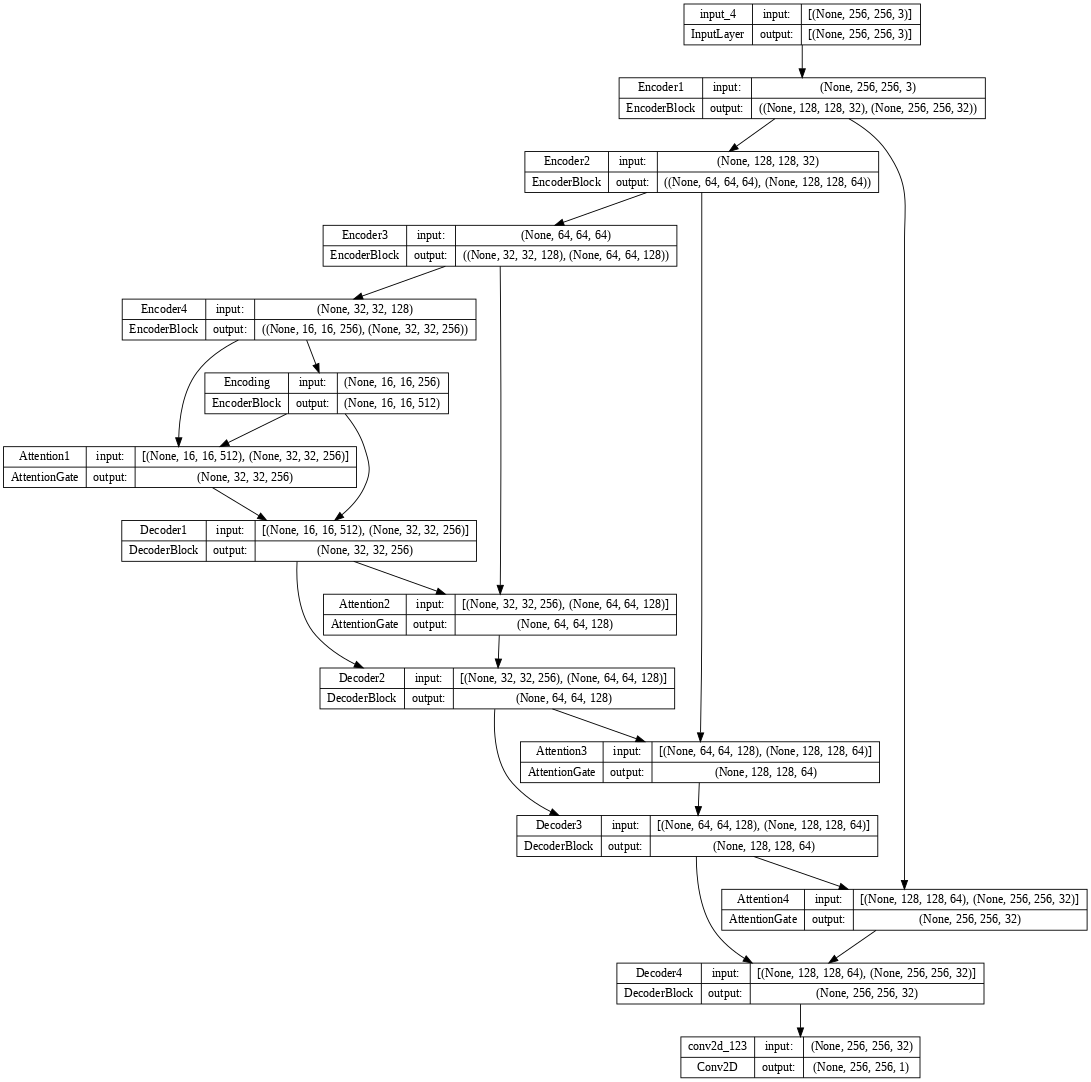

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=64)

In [ ]:
BATCH_SIZE = 6  
SPE = len(image_data)//BATCH_SIZE

## Model Training

Epoch 1/20
1/1 [==============================] - 0s 33ms/step


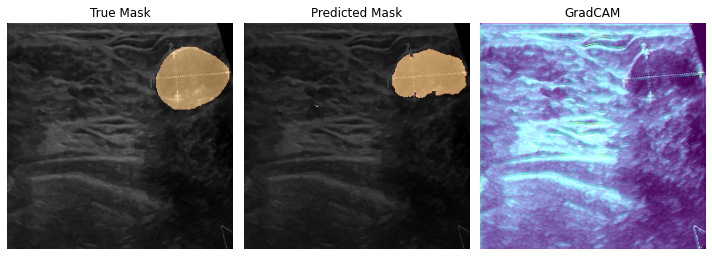

130/130 [==============================] - 30s 227ms/step - loss: 0.1318 - accuracy: 0.9524 - IoU: 0.3075 - val_loss: 0.1523 - val_accuracy: 0.9523 - val_IoU: 0.4704
Epoch 2/20
1/1 [==============================] - 0s 25ms/step


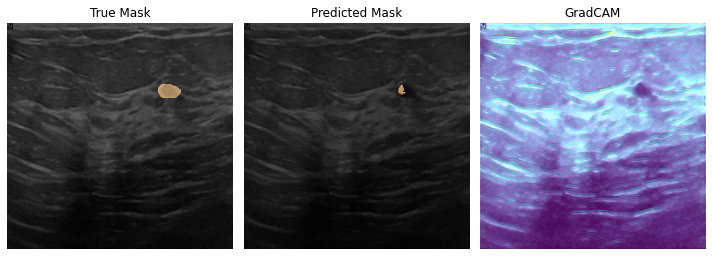

130/130 [==============================] - 29s 224ms/step - loss: 0.1270 - accuracy: 0.9534 - IoU: 0.3059 - val_loss: 0.1616 - val_accuracy: 0.9500 - val_IoU: 0.4704
Epoch 3/20
1/1 [==============================] - 0s 33ms/step


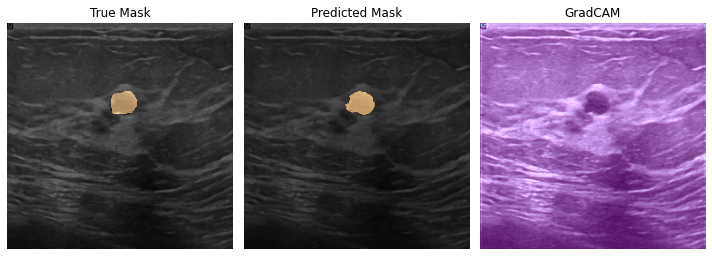

130/130 [==============================] - 30s 229ms/step - loss: 0.1232 - accuracy: 0.9555 - IoU: 0.3068 - val_loss: 0.1410 - val_accuracy: 0.9491 - val_IoU: 0.4704
Epoch 4/20
1/1 [==============================] - 0s 37ms/step


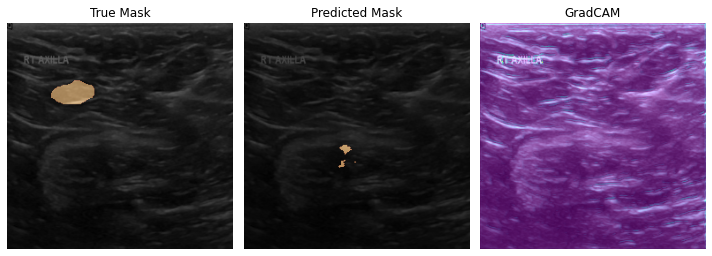

130/130 [==============================] - 29s 227ms/step - loss: 0.1101 - accuracy: 0.9589 - IoU: 0.3087 - val_loss: 0.1722 - val_accuracy: 0.9363 - val_IoU: 0.4705
Epoch 5/20
1/1 [==============================] - 0s 28ms/step


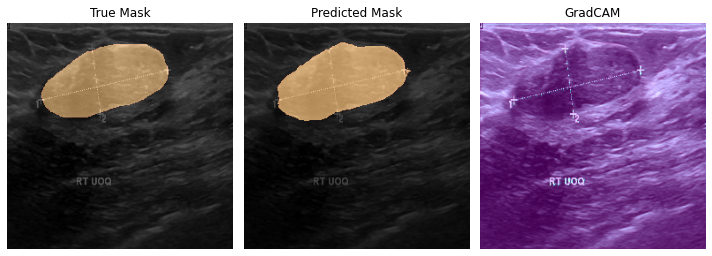

130/130 [==============================] - 30s 230ms/step - loss: 0.1062 - accuracy: 0.9608 - IoU: 0.3093 - val_loss: 0.1323 - val_accuracy: 0.9570 - val_IoU: 0.4704
Epoch 6/20
1/1 [==============================] - 0s 46ms/step


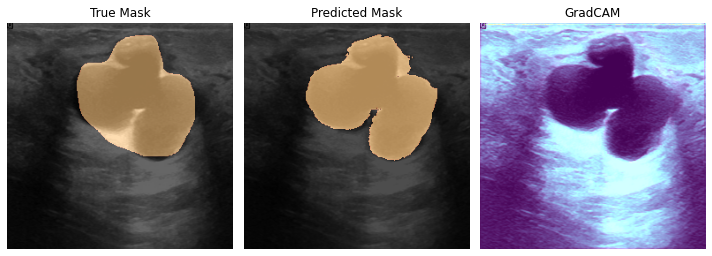

130/130 [==============================] - 30s 233ms/step - loss: 0.1044 - accuracy: 0.9612 - IoU: 0.3091 - val_loss: 0.1247 - val_accuracy: 0.9610 - val_IoU: 0.4704
Epoch 7/20
1/1 [==============================] - 0s 26ms/step


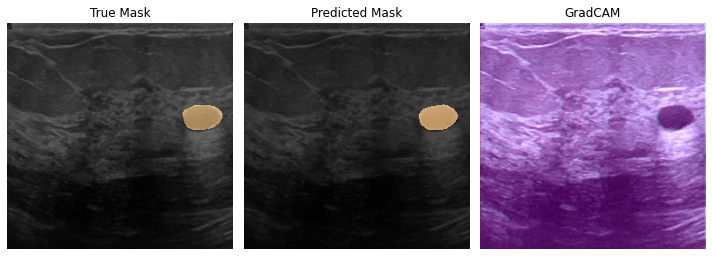

130/130 [==============================] - 29s 221ms/step - loss: 0.1048 - accuracy: 0.9614 - IoU: 0.3081 - val_loss: 0.1272 - val_accuracy: 0.9580 - val_IoU: 0.4704
Epoch 8/20
1/1 [==============================] - 0s 25ms/step


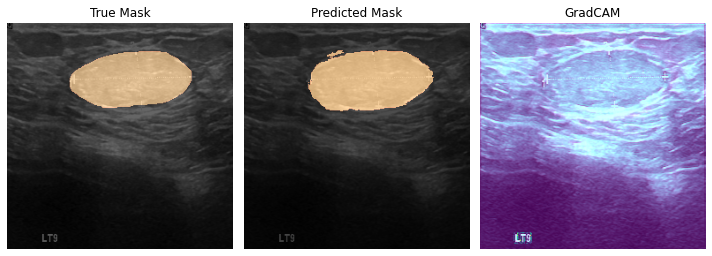

130/130 [==============================] - 29s 227ms/step - loss: 0.0949 - accuracy: 0.9641 - IoU: 0.3098 - val_loss: 0.1620 - val_accuracy: 0.9561 - val_IoU: 0.4704
Epoch 9/20
1/1 [==============================] - 0s 32ms/step


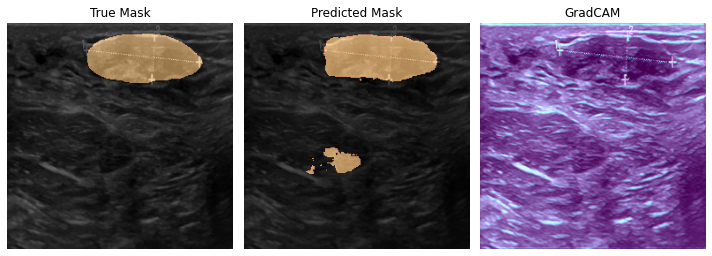

130/130 [==============================] - 30s 227ms/step - loss: 0.0895 - accuracy: 0.9656 - IoU: 0.3143 - val_loss: 0.1432 - val_accuracy: 0.9538 - val_IoU: 0.4704
Epoch 10/20
1/1 [==============================] - 0s 24ms/step


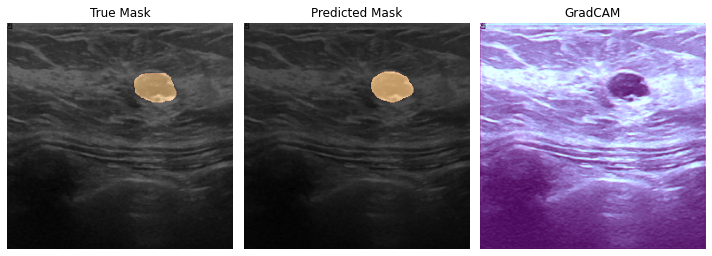

130/130 [==============================] - 29s 222ms/step - loss: 0.0947 - accuracy: 0.9639 - IoU: 0.3161 - val_loss: 0.1485 - val_accuracy: 0.9482 - val_IoU: 0.4704
Epoch 11/20
1/1 [==============================] - 0s 24ms/step


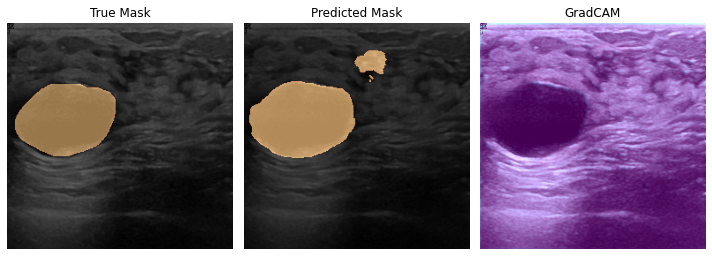

130/130 [==============================] - 30s 228ms/step - loss: 0.0908 - accuracy: 0.9649 - IoU: 0.3160 - val_loss: 0.1362 - val_accuracy: 0.9523 - val_IoU: 0.4705
Epoch 12/20
1/1 [==============================] - 0s 25ms/step


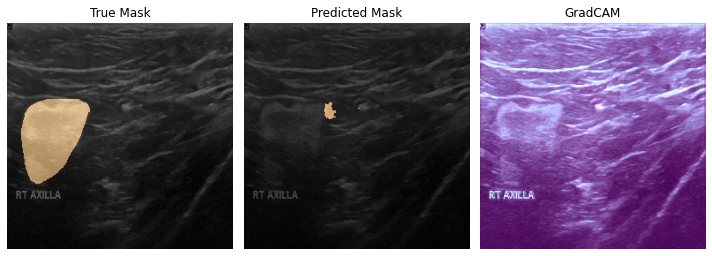

130/130 [==============================] - 29s 222ms/step - loss: 0.0852 - accuracy: 0.9666 - IoU: 0.3151 - val_loss: 0.1794 - val_accuracy: 0.9345 - val_IoU: 0.4716
Epoch 13/20
1/1 [==============================] - 0s 24ms/step


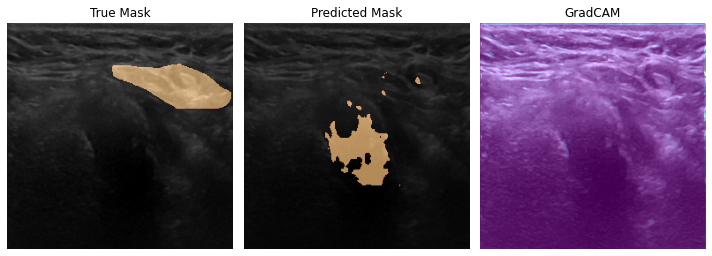

130/130 [==============================] - 30s 230ms/step - loss: 0.0826 - accuracy: 0.9680 - IoU: 0.3139 - val_loss: 0.1165 - val_accuracy: 0.9608 - val_IoU: 0.4704
Epoch 14/20
1/1 [==============================] - 0s 36ms/step


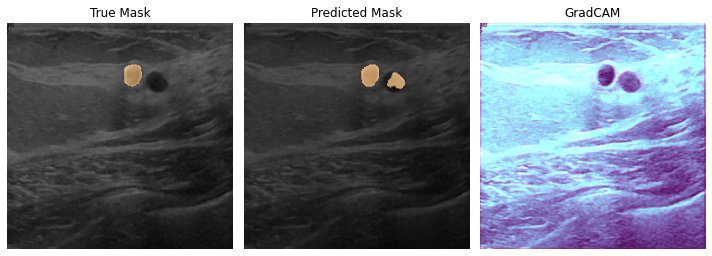

130/130 [==============================] - 29s 222ms/step - loss: 0.0752 - accuracy: 0.9710 - IoU: 0.3235 - val_loss: 0.1394 - val_accuracy: 0.9500 - val_IoU: 0.4704
Epoch 15/20
1/1 [==============================] - 0s 31ms/step


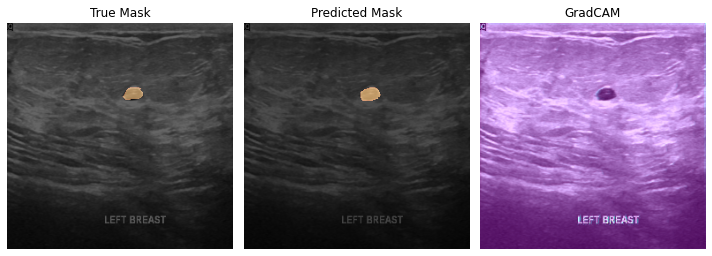

130/130 [==============================] - 3s 24ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - IoU: 0.0000e+00 - val_loss: 0.1394 - val_accuracy: 0.9500 - val_IoU: 0.4704


In [ ]:
results = model.fit(
    image_data, mask_data,
    validation_split=0.3,
    epochs=20,
    steps_per_epoch=SPE,
    batch_size=BATCH_SIZE,
    callbacks=cb
)

## Model Evaluation

In [ ]:
loss, accuracy, iou, val_loss, val_accuracy, val_iou = results.history.values()

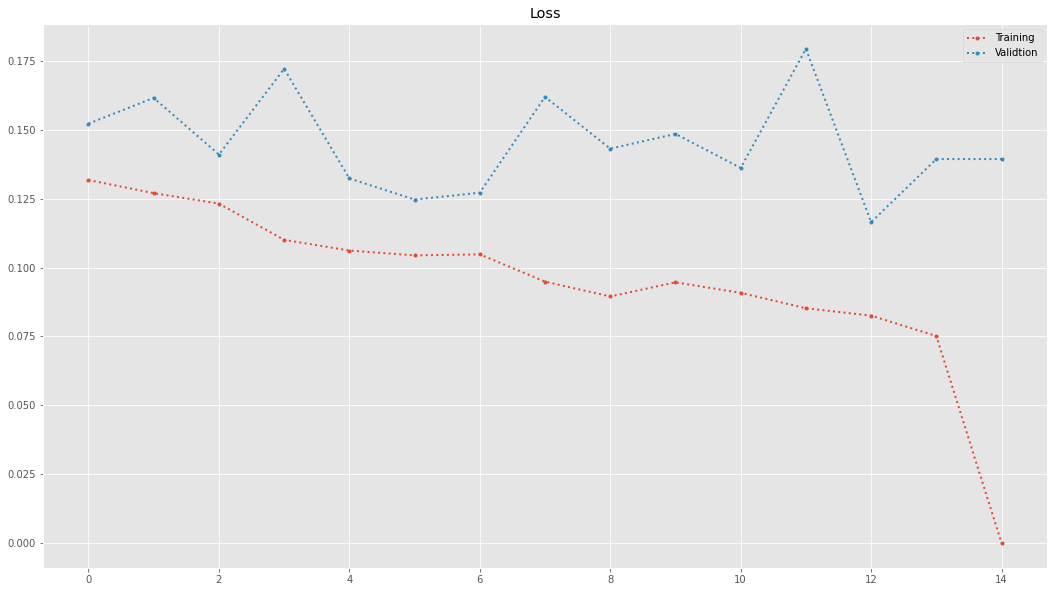

In [ ]:
plt.figure(figsize=(18,10))

plt.title("Loss")
plt.plot(loss, ".:", label="Training", linewidth=2)
plt.plot(val_loss, ".:", label="Validtion", linewidth=2)
plt.legend()
plt.show()

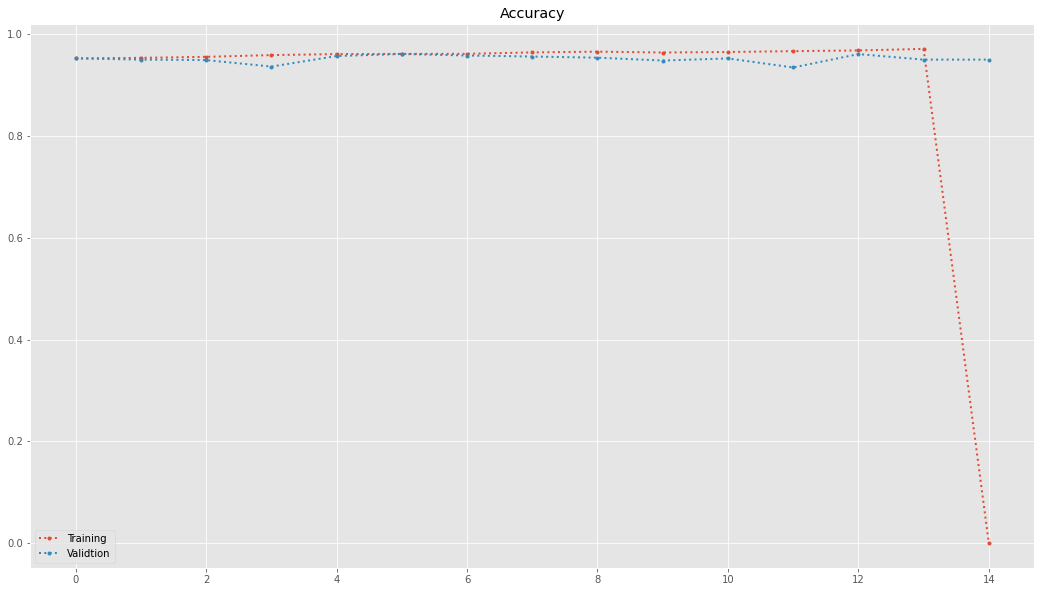

In [ ]:
plt.figure(figsize=(18,10))
plt.title("Accuracy")
plt.plot(accuracy, ".:", label="Training", linewidth=2)
plt.plot(val_accuracy, ".:", label="Validtion", linewidth=2)
plt.legend()
plt.show()

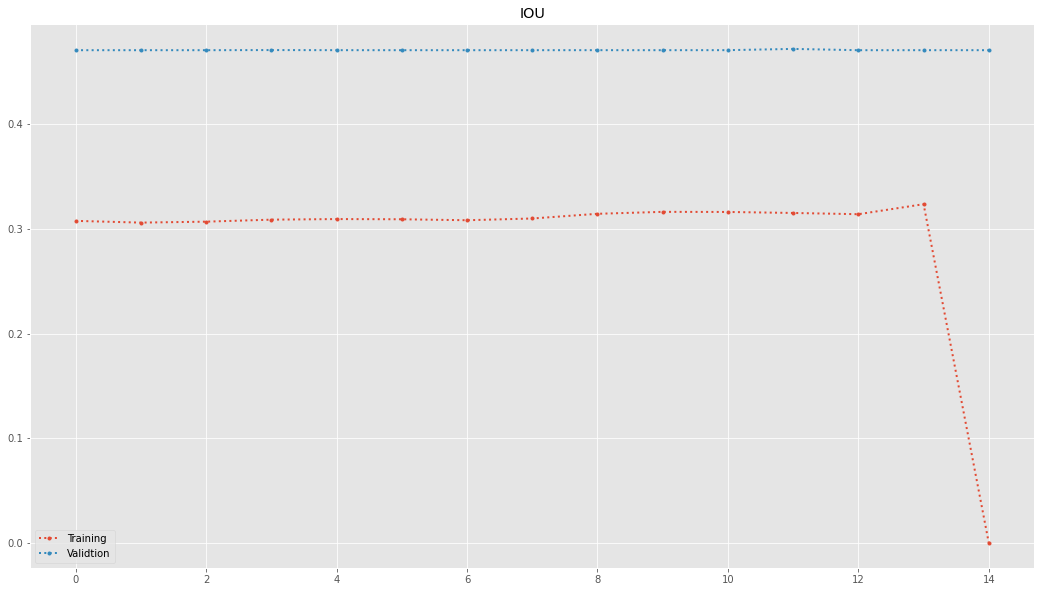

In [ ]:
plt.figure(figsize=(18,10))
plt.title("IOU")
plt.plot(iou, ".:", label="Training", linewidth=2)
plt.plot(val_iou, ".:", label="Validtion", linewidth=2)
plt.legend()
plt.show()

## Model Testing and Predication

1/1 [==============================] - 0s 25ms/step


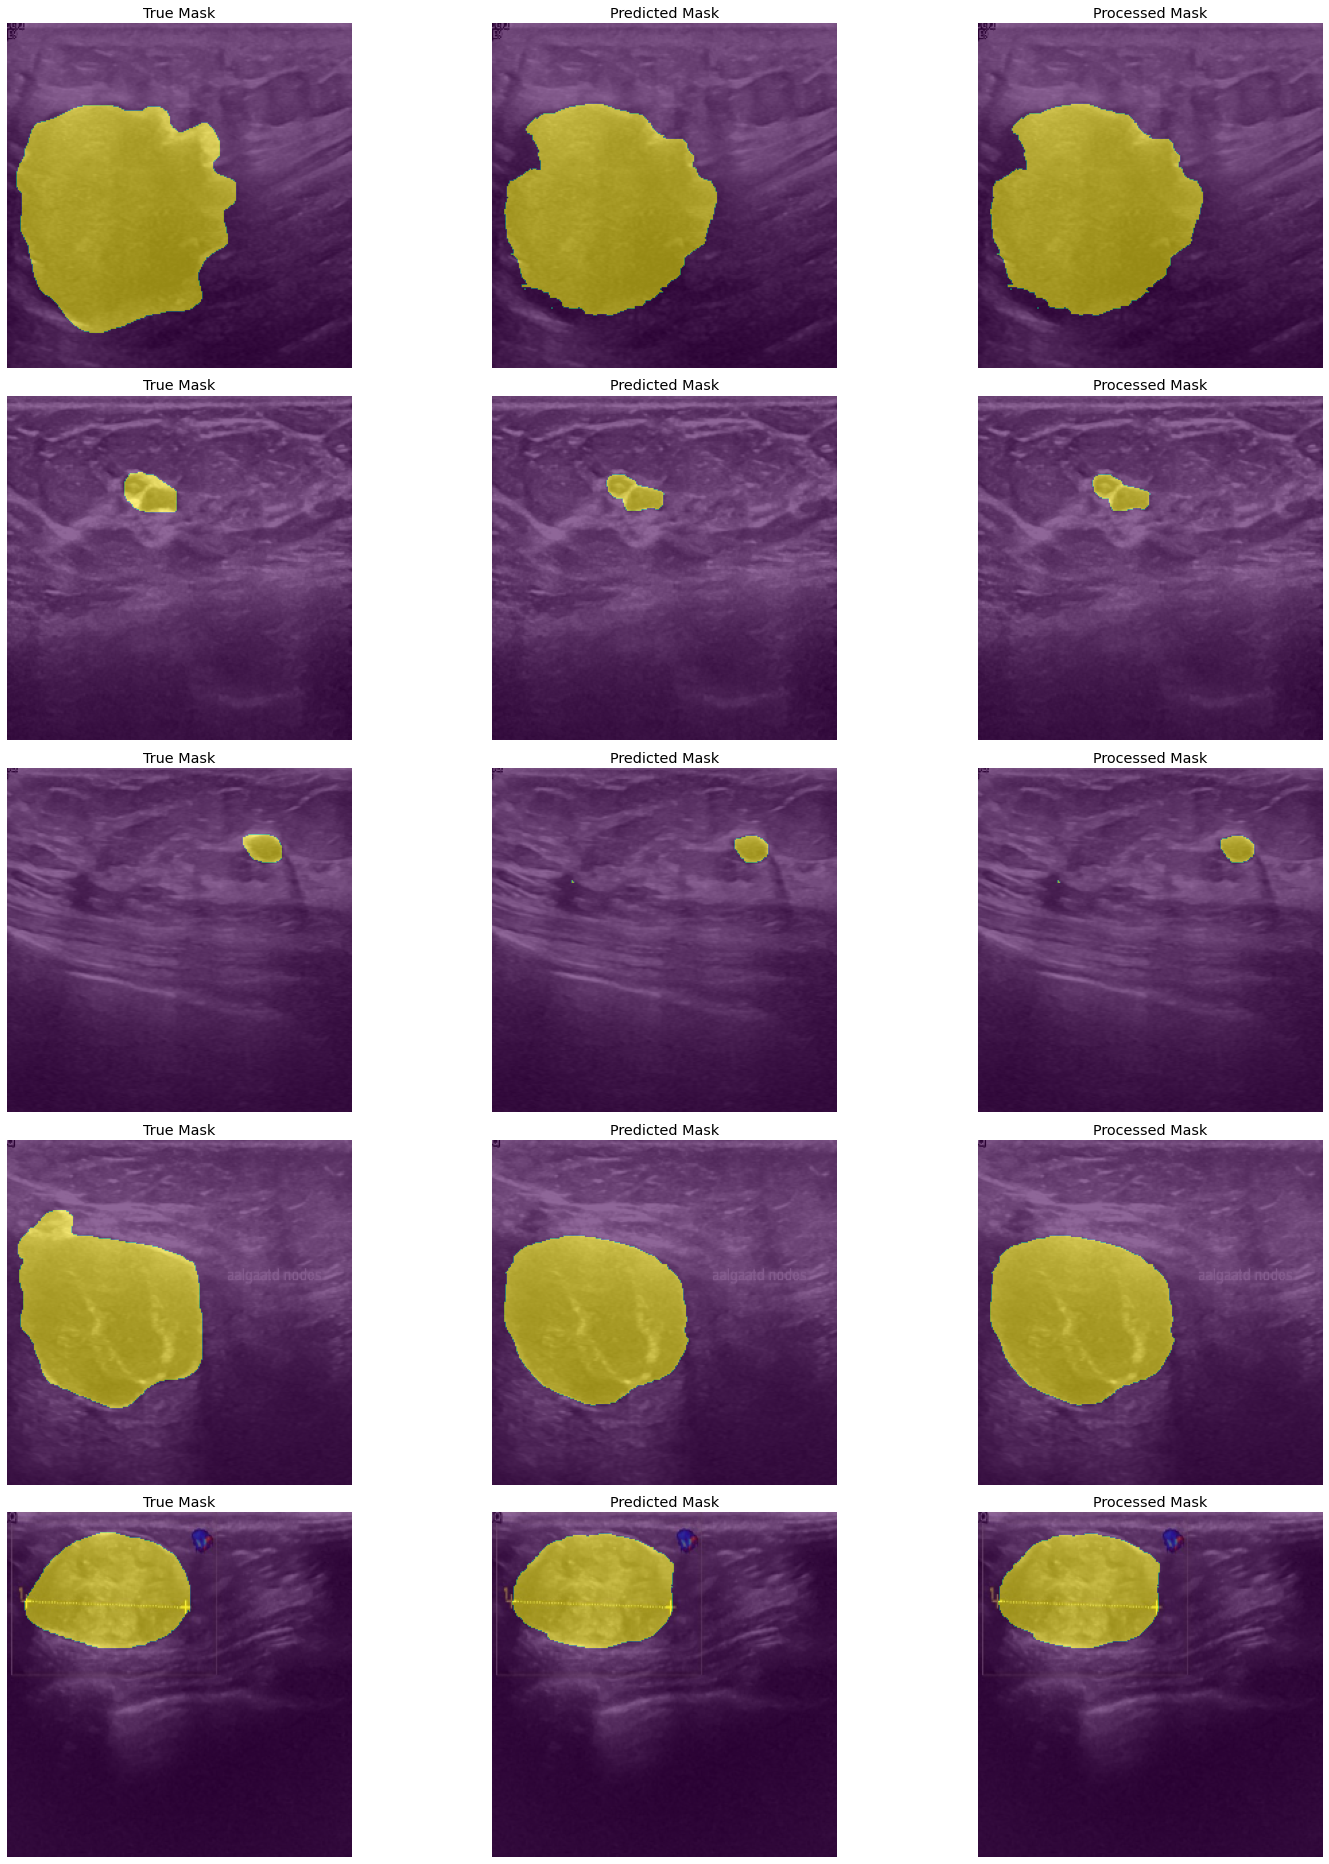

In [ ]:
plt.figure(figsize=(22,26))
n=0
for i in range(1,(5*3)+1):
  plt.subplot(5,3,i)
  if n==0:
      id = np.random.randint(len(image_data))
      image = image_data[id]
      mask = mask_data[id]
      pred_mask = model.predict(image[np.newaxis,...])

      show_mask(image, mask, alpha=0.6,title='True Mask')
      n+=1
  elif n==1:
      show_mask(image, pred_mask, alpha=0.6, title='Predicted Mask')
      n+=1
  elif n==2:
      pred_mask = (pred_mask>0.5).astype('float')
      show_mask(image, pred_mask, alpha=0.6, title='Processed Mask')
      n=0
plt.tight_layout()
plt.show()